# Visualization of the latent space

In [1]:
print('hello')

hello


## Imports

In [2]:
import ipywidgets as widgets
from IPython.display import display
from matplotlib import pyplot as plt 
import numpy as np
import json
import os
import sys
from glob import glob
from pathlib import Path
#from attrdict import AttrDict
from matplotlib import pyplot as plt
import numpy as np
import pickle
import imageio
from scipy import ndimage
import torch
import torch.nn as nn
import torch.nn.functional as F
import ipywidgets as widgets

from ipywidgets import interactive, fixed
import collections
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.Sequence = collections.abc.Sequence
collections.MutableSet = collections.abc.MutableSet

%matplotlib ipympl

In [3]:
print(os.getcwd())

/home/gesa/0neueWelt/Desy/betaVAEDemo


In [4]:
from configs import parse_configuration_yaml
from evaluation import get_trained_model
from datasets.gmd_charge_labels_seeded_dataset import GMDChargeLabelsSeededDataset

/home/gesa/micromamba/envs/mamba2023/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Definitions

In [5]:
config_dir = '../configs/'
flare = False

config_names = ['x016.yaml', 'x016.yaml'] #'n23ov001.yaml']#[os.path.join(config_dir,'pc{:03d}'.format(i),'pc{:03d}.json'.format(i)) for i in model_nr]

if flare:
    pass
    #config_names = [ 'n23ov002.yaml']

config_files = [config_dir + cn for cn in config_names]

#FEBruar
input_im = './data/test_dataWidgets.npy'
if flare:
    input_im = './data/FLARENOV.npy'

n_slider = 10
min_slider = -5
max_slider = 5
step_slider = 0.1

def adapt_cponfig(config):
    config['callbacks']['checkpoint_time']['dirpath'] = './checkpoints/' 
    
    return config

# load images, models... 

In [6]:
# load images
im_arr = np.load(input_im)/255.
im_dict = {'Im{:02d}'.format(n): im_arr[n] for n in range(im_arr.shape[0])}

#FLARE
if flare:
    im_dict = {'run{:02d}'.format(n+49465): im_arr[n] for n in range(im_arr.shape[0]) if not n==49489}


#load models
model_dict = {}
for config_name, config_file in zip(config_names,config_files):
    config = parse_configuration_yaml(config_file)
    config = adapt_cponfig(config)
    model = get_trained_model(config, device = 'cpu', rootpath_config='./')
    model_name = config_name.split('.')[0]
    model_dict[model_name] = model


# Visualization

### Define interactive elements





In [7]:
dropdownModel = widgets.Dropdown(
    options=list(model_dict.keys()),
    value=list(model_dict.keys())[0],
    description='Model:',
)


dropdownImage = widgets.Dropdown(
    value = list(im_dict.keys())[0],
    options=list(im_dict.keys()),
    description='Image:',
)

z_slider_list = [
     widgets.FloatSlider(
        value=0,
        min=min_slider,
        max=max_slider,
        step=step_slider,
        description=f'$z_{{{n}}}$',
        orientation='vertical'
    )
    for n in range(n_slider)

]


resizeCBButton = widgets.Button(description = 'resize Cbar')

resetzButton = widgets.Button(description = 'z to zero')

ztoImButton = widgets.Button(description = 'z to Im')

### define and link watch functions

In [8]:

def update_reconstruction(change):
    decoder = model_dict[dropdownModel.value].decoder
    
    values = [slider.value for slider in z_slider_list]
    z = torch.tensor(values)[None, :].detach().cpu()
    y = np.array(decoder(z).detach()[0,0])
    imobj.set_array(y)
    
    
    image_str = dropdownImage.value
    new_image = im_dict[image_str]    
    try:
        diff_image = new_image/np.sum(new_image)   -y/np.sum(y)
        diffobj.set_array(diff_image)
        vmax = max(np.abs(np.min(diff_image)), np.max(diff_image))
        diffobj.set_clim([-vmax, vmax])
    except ValueError as ve:
        print('WARNING, example data and model does not match!')
        print(ve)

for z_slider in z_slider_list:    
    z_slider.observe(update_reconstruction, names='value')
    
dropdownModel.observe(update_reconstruction)    
    

def resizeCB(change):
    new_img = imobj.get_array()
    imobj.set_clim([new_img.min(), new_img.max()])    
    
resizeCBButton.on_click(resizeCB)


    
def load_image(change):
    image_str = dropdownImage.value
    new_image = im_dict[image_str]                      
    dataobj.set_array(new_image)
    dataobj.set_clim([new_image.min(), new_image.max()])
    
    try:
        encoder = model_dict[dropdownModel.value].encoder
        with torch.no_grad():
            z = encoder(torch.tensor(new_image[None,], dtype = torch.float32))[0]
        z = z.numpy()
        for z_value,z_slider in zip(z,z_slider_list):    
            z_slider.value = z_value
    except RuntimeError as re:
        print('WARNING, example data and model does not match!')
        print(re)
            
    
dropdownImage.observe(load_image)
ztoImButton.on_click(load_image)

def reset_z(change):    
    for z_slider in z_slider_list:    
        z_slider.value = 0
resetzButton.on_click(reset_z)

### plot and display

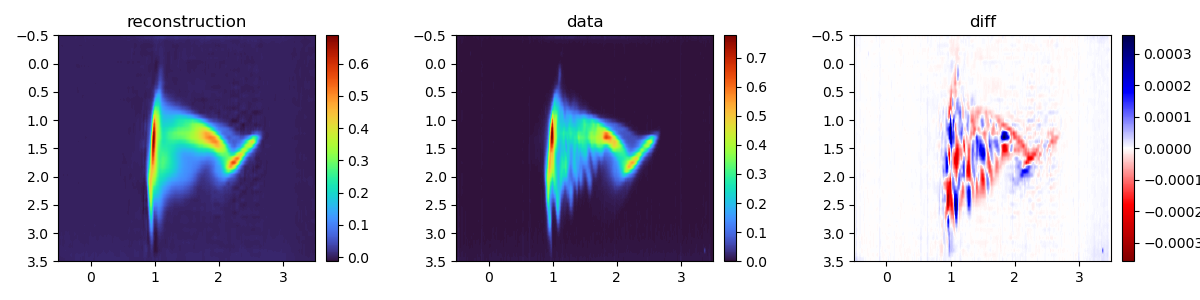

In [9]:

plt.close('all')
fig, ax = plt.subplots(1,3, num = 'such a nice figure', dpi=100, figsize=[12,3])
imobj = ax[0].imshow((np.random.randn(4,4)), cmap = 'turbo', aspect = 'auto')
ax[0].set_title('reconstruction')
cbobj = plt.colorbar(imobj,fraction=0.046, pad=0.04)

dataobj = ax[1].imshow((np.zeros((4,4))), cmap = 'turbo', aspect = 'auto')
cbobjdata = plt.colorbar(dataobj,fraction=0.046, pad=0.04)
ax[1].set_title('data')
plt.tight_layout()


diffobj = ax[2].imshow((np.zeros((4,4))), cmap = 'seismic_r', vmin = -1, vmax = 1, aspect = 'auto')
cbobjdiff = plt.colorbar(diffobj,fraction=0.046, pad=0.04)
ax[2].set_title('diff')
plt.tight_layout()



optionsbox = widgets.HBox([resizeCBButton, resetzButton, ztoImButton, dropdownModel, dropdownImage])



if n_slider==20:
    sliderbox0 = widgets.HBox(z_slider_list[:10])
    sliderbox1 = widgets.HBox(z_slider_list[10:])
    display(sliderbox0,sliderbox1, optionsbox)

else:
    sliderbox = widgets.HBox(z_slider_list)
    display(sliderbox, optionsbox)

update_reconstruction(None)
load_image(None)
resizeCB(None)

In [10]:
x011: 
    z0  - intensity near pulse head
    z1 - y coordinate of reconsruction
    z2 - lasing
    z3 - intensity near pulse head 
    z4 - electron pulse len
    z5 - x position of lasing
    z6 - x position of lasing
    z7 - intensity in pulse head
    z8 - lefr/right?
    z9 - y coordinate of reconsruction

SyntaxError: invalid syntax (3120057556.py, line 1)

In [ ]:
x016: 
    z0  - intensity near pulse head
    z1 - y coordinate of reconsruction
    z2 - lasing
    z3 - intensity near pulse head 
    z4 - electron pulse len !
    z5 - x position of lasing
    z6 - x position of lasing
    z7 - intensity in pulse head !
    z8 - lefr/right?
    z9 - y coordinate of reconsruction 